# Import software libraries and load the dataset #

In [1]:
import sys                             # Read system parameters.
import os                              # Interact with the operating system.
import numpy as np                     # Work with multi-dimensional arrays and matrices.
import pandas as pd                    # Manipulate and analyze data.
import matplotlib                      # Create 2D charts.
import matplotlib.pyplot as plt
import seaborn as sb                   # Perform data visualization.
import sklearn                         # Perform data mining and analysis.
from time import time                  # Calculate training time.

# Summarize software libraries used.
print('Libraries used in this project:')
print('- Python {}'.format(sys.version))
print('- NumPy {}'.format(np.__version__))
print('- pandas {}'.format(pd.__version__))
print('- Matplotlib {}'.format(matplotlib.__version__))
print('- Seaborn {}'.format(sb.__version__))
print('- scikit-learn {}\n'.format(sklearn.__version__))

# Load the dataset.
PROJECT_ROOT_DIR = "."
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "titanic_data")
print('Data files in this project:', os.listdir(DATA_PATH))
data_raw_file = os.path.join(DATA_PATH, 'train.csv')
data_raw = pd.read_csv(data_raw_file)
print('Loaded {} records from {}.'.format(len(data_raw), data_raw_file))

Libraries used in this project:
- Python 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
[GCC 7.3.0]
- NumPy 1.16.2
- pandas 0.24.2
- Matplotlib 3.0.3
- Seaborn 0.9.0
- scikit-learn 0.20.3

Data files in this project: ['train.csv', 'test.csv']
Loaded 891 records from ./titanic_data/train.csv.


# Split the datasets

In [2]:
# Separate training and test sets already exist.
# A validation set will be split off from the training sets.

from sklearn.model_selection import train_test_split

# 'Survived' is the dependent variable (value to be predicted), so it will be
# removed from the training data and put into a separate DataFrame for labels.
label_columns = ['Survived']

training_columns = ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

# Split the training and validation datasets and their labels.
X_train, X_val, y_train, y_val = train_test_split(data_raw[training_columns],
                                                                            data_raw[label_columns],
                                                                            random_state = 1912)

print('The datasets and labels have been split.')

The datasets and labels have been split.


# Perform common preparation on the training and validation sets

In [3]:
# Perform common cleaning and feature engineering tasks on datasets.
def prep_dataset(dataset):
    
    # PROVIDE MISSING VALUES
    
    # Fill missing Age values with the median age.
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)

    # Fill missing Fare values with the median fare.
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)

    # Fill missing Embarked values with the mode.
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)
    
    # ONE-HOT ENCODING
    
    cols = ['Pclass', 'Sex', 'Embarked']
    
    for i in cols:
        dummies = pd.get_dummies(dataset[i], prefix = i, drop_first = False)
        dataset = pd.concat([dataset, dummies], axis = 1)

    return dataset

X_train = prep_dataset(X_train.copy())

X_val = prep_dataset(X_val.copy())

print('The datasets have been cleaned and prepared.')

The datasets have been cleaned and prepared.


# Drop columns that won't be used for training

In [4]:
# Drop unused columns from datasets.
def drop_unused(dataset):
        
    dataset = dataset.drop(['PassengerId'], axis = 1)
    dataset = dataset.drop(['Cabin'], axis = 1)
    dataset = dataset.drop(['Ticket'], axis = 1)
    dataset = dataset.drop(['Name'], axis = 1)

    # These have been replaced with one-hot encoding.
    dataset = dataset.drop(['Pclass'], axis = 1)
    dataset = dataset.drop(['Sex'], axis = 1)
    dataset = dataset.drop(['Embarked'], axis = 1)
    
    return dataset

X_train = drop_unused(X_train.copy())

X_val = drop_unused(X_val.copy())

print('Unused columns have been dropped.')

Unused columns have been dropped.


# Create a random forest model

In [5]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators = 100,
                                criterion = 'gini',
                                max_depth = 6,
                                min_samples_leaf = 10,
                                min_samples_split = 78,
                                bootstrap = True,
                                oob_score = True,
                                random_state = 1912)

forest.fit(X_train, np.ravel(y_train))

prediction = forest.predict(X_val)

# Score using the validation data.
score = forest.score(X_val, y_val)

print('Accuracy: {:.0f}%'.format(score * 100))

Accuracy: 83%


# Visualize the structure of one decision tree in the forest

In [6]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image, display 
import pydotplus as pdotp

def plot_tree(model, image):
    dot_data = StringIO()
    export_graphviz(model, out_file = dot_data, 
                    filled = True,
                    rounded = True,
                    special_characters = True, 
                    feature_names = X_train.columns.values.tolist(),
                    class_names = ['0', '1'])

    graph = pdotp.graph_from_dot_data(dot_data.getvalue())  
    graph.write_png(image)
    Image(graph.create_png())
    
print('The visualization function has been defined.')

The visualization function has been defined.


# Compute accuracy, precision, recall, and F<sub>1</sub> score

In [7]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def model_scores(y, prediction):
    acc = accuracy_score(y, prediction)
    print('Accuracy: {:.0f}%'.format(np.round(acc * 100)))
    
    precision = precision_score(y, prediction)
    print('Precision: {:.0f}%'.format(np.round(precision * 100)))
    
    recall = recall_score(y, prediction)
    print('Recall: {:.0f}%'.format(np.round(recall * 100)))
    
    f1 = f1_score(y, prediction)
    print('F1: {:.0f}%'.format(np.round(f1 * 100)))
    
print('The function to show the scores has been defined.')

The function to show the scores has been defined.


# Generate a ROC curve and compute the AUC

In [8]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def roc(y, prediction_proba):
    fpr, tpr, thresholds = roc_curve(y, prediction_proba)
    
    plt.plot(fpr, tpr);
    plt.xlim([0.0, 1.0]);
    plt.ylim([0.0, 1.0]);
    plt.title('ROC Curve');
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate');
    plt.grid(True);
    
    auc = roc_auc_score(y, prediction_proba)
    print('Area Under Curve: {:.2f}'.format(auc))
    
print('The function to generate the ROC curve and compute AUC has been defined.')

The function to generate the ROC curve and compute AUC has been defined.


# Generate a precision–recall curve and compute the average precision

In [9]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

def prc(y, prediction_proba):
    precision, recall, thresholds = precision_recall_curve(y, prediction_proba)
    
    plt.plot(recall, precision);
    plt.xlim([0.0, 1.0]);
    plt.ylim([0.0, 1.0]);
    plt.title('Precision–Recall Curve');
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    plt.grid(True);
    
    ap = average_precision_score(y, prediction_proba)
    print('Average Precision: {:.2f}'.format(ap))
    
print('The function to generate a PRC and compute average precision has been defined.')

The function to generate a PRC and compute average precision has been defined.


# Examine a couple of trees in the forest

In [10]:
# Install the required library.
!conda install --yes graphviz==2.40.1

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.



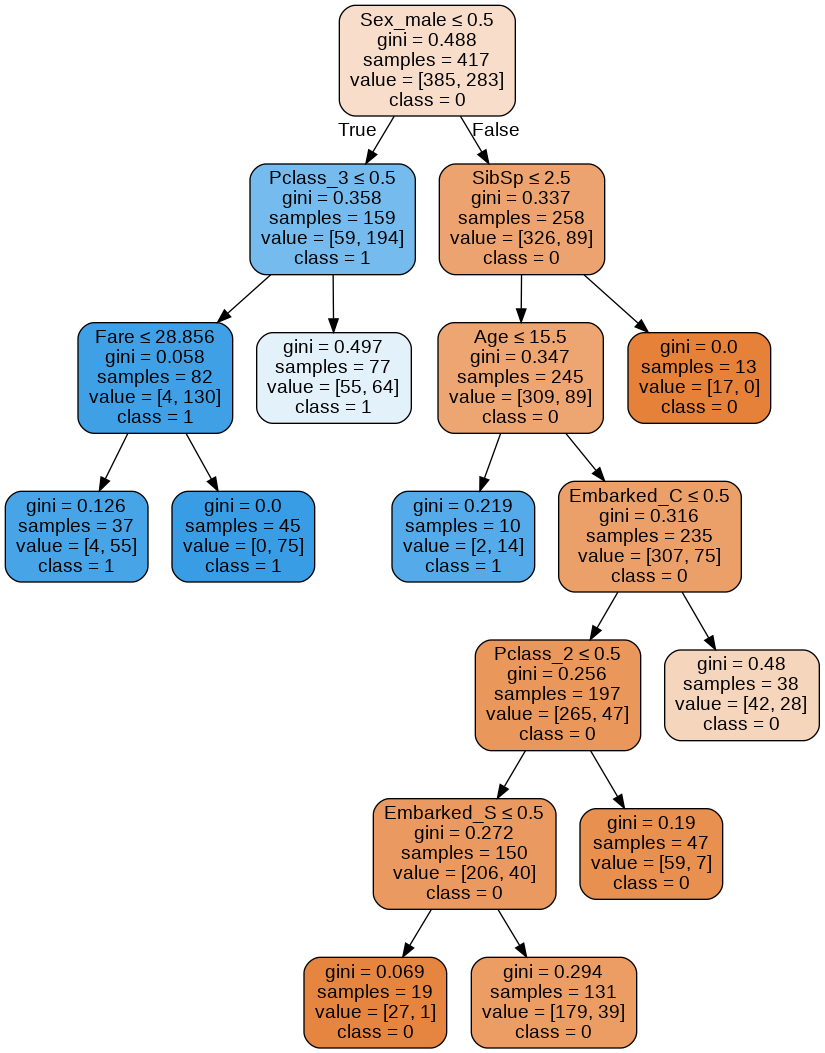

In [11]:
plot_tree(forest.estimators_[0], 'titanic_forest_tree0.png')
display(Image('titanic_forest_tree0.png'))

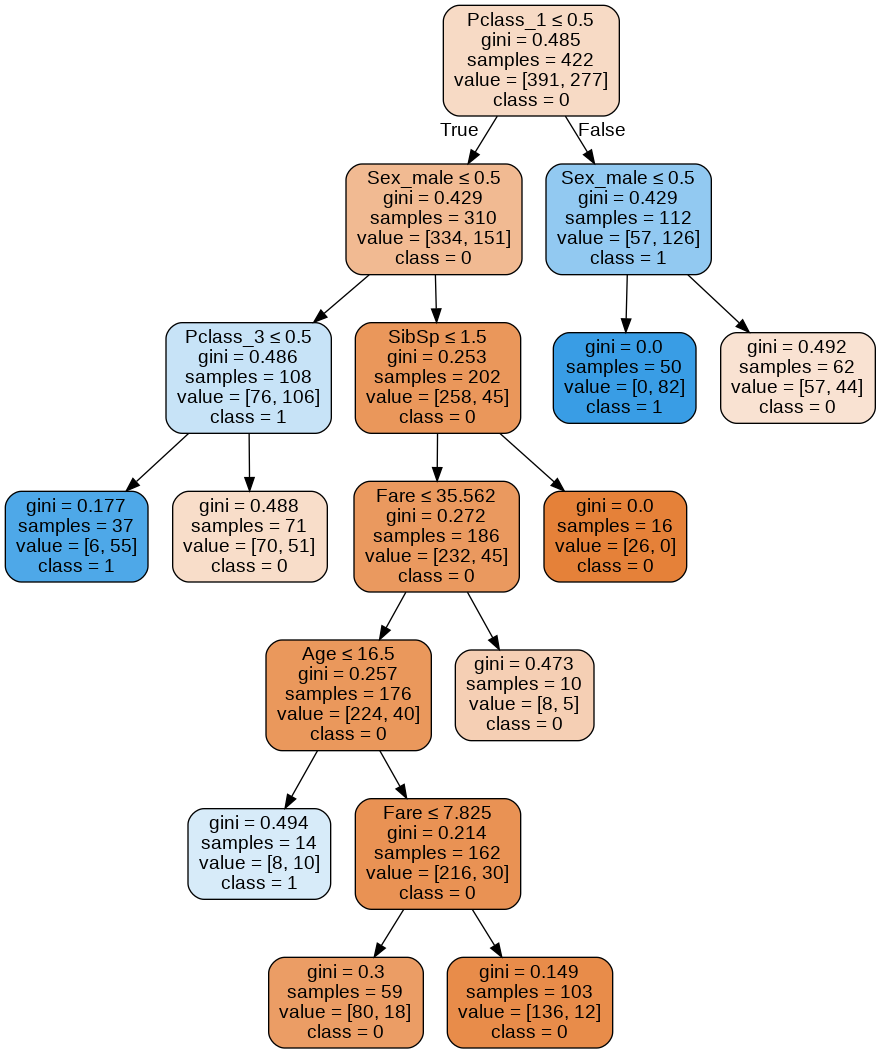

In [12]:
plot_tree(forest.estimators_[1], 'titanic_forest_tree1.png')
display(Image('titanic_forest_tree1.png'))

# Evaluate the random forest model

In [13]:
model_scores(y_val, prediction)

Accuracy: 83%
Precision: 80%
Recall: 67%
F1: 73%


Area Under Curve: 0.85


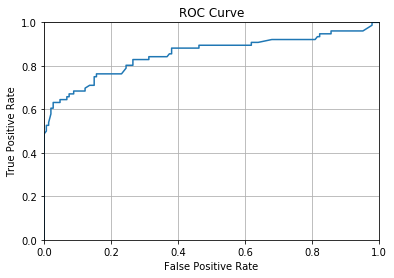

In [14]:
predict_proba = forest.predict_proba(X_val)

roc(y_val, predict_proba[:, 1])

Average Precision: 0.84


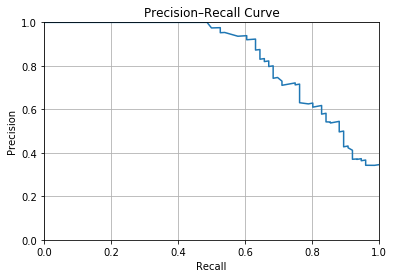

In [15]:
prc(y_val, predict_proba[:, 1])

# Generate the out-of-bag error and decision function

In [16]:
oob_error = 1 - forest.oob_score_
print('Out-of-bag error: {}'.format(round(oob_error, 3)))

Out-of-bag error: 0.22


In [17]:
forest.oob_decision_function_

array([[0.83990492, 0.16009508],
       [0.44309796, 0.55690204],
       [0.88436021, 0.11563979],
       ...,
       [0.72455935, 0.27544065],
       [0.43065855, 0.56934145],
       [0.18766646, 0.81233354]])

# Verify that the random forest took the majority vote of all trees in the forest

In [18]:
from statistics import mode

class_list = []
class_mode = []
i = 0

for i in range(10):  # Get predictions for the first 10 data examples.
    for tree in forest.estimators_:  # Get predictions from all trees in forest.
        predict = tree.predict(X_val)
        predict_examples = predict[i]
        class_list.append(predict_examples)

    # Get mode of predictions to determine majority vote for each example.   
    class_mode.append(int(mode(class_list)))
    class_list = []

print('Majority vote classification:    {}'.format(np.array(class_mode)))
print('Random forest classification:    {}'.format(forest.predict(X_val)[0:10]))

Majority vote classification:    [0 0 0 1 0 1 1 0 0 0]
Random forest classification:    [0 0 0 1 0 1 1 0 0 0]


# Identify important features

In [19]:
# Get feature importances.
feature_importances = list(forest.feature_importances_)

# Get column names.
feature_list = list(X_train)

importances_list = []

# Map feature/importance indices and put into a single list.
for feature, importance in zip(feature_list, feature_importances):
    importances_list.append((feature, round(importance, 2)))

# Sort list by importance index.
importances_list = sorted(importances_list, key = lambda i: i[1], reverse = True)

for feature, importance in importances_list:
    print('Feature: {:10} | Importance: {}'.format(feature, importance))

Feature: Sex_female | Importance: 0.34
Feature: Sex_male   | Importance: 0.25
Feature: Pclass_3   | Importance: 0.11
Feature: Fare       | Importance: 0.1
Feature: Pclass_1   | Importance: 0.06
Feature: Age        | Importance: 0.04
Feature: SibSp      | Importance: 0.02
Feature: Parch      | Importance: 0.02
Feature: Pclass_2   | Importance: 0.02
Feature: Embarked_C | Importance: 0.02
Feature: Embarked_S | Importance: 0.01
Feature: Embarked_Q | Importance: 0.0


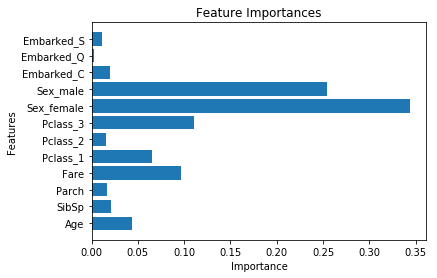

In [20]:
y_values = list(range(len(feature_importances)))
plt.barh(y_values, feature_importances)
plt.yticks(y_values, feature_list, rotation='horizontal')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances');

# Select the most important features to use for a new round of training

In [21]:
X_train = X_train[['Sex_female', 'Sex_male', 'Pclass_3', 'Fare']].copy()
X_val = X_val[['Sex_female', 'Sex_male', 'Pclass_3', 'Fare']].copy()

X_train.head()

,Sex_female,Sex_male,Pclass_3,Fare
439,0,1,0,10.5000
617,1,0,1,16.1000
242,0,1,0,10.5000
82,1,0,1,7.7875
398,0,1,0,10.5000


# Train a new random forest model on the dataset with reduced dimensionality

In [22]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators = 100,
                                criterion = 'gini',
                                max_depth = 6,
                                min_samples_leaf = 10,
                                min_samples_split = 78,
                                bootstrap = True,
                                oob_score = True,
                                random_state = 1912)

forest.fit(X_train, np.ravel(y_train))

prediction = forest.predict(X_val)

# Score using the validation data.
score = forest.score(X_val, y_val)

print('Accuracy: {:.0f}%'.format(score * 100))

Accuracy: 84%


# Evaluate the new random forest model

In [23]:
model_scores(y_val, prediction)

Accuracy: 84%
Precision: 82%
Recall: 67%
F1: 74%


Area Under Curve: 0.85


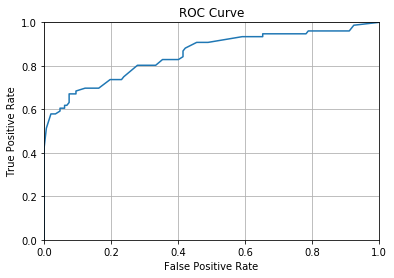

In [24]:
predict_proba = forest.predict_proba(X_val)

roc(y_val, predict_proba[:, 1])

Average Precision: 0.83


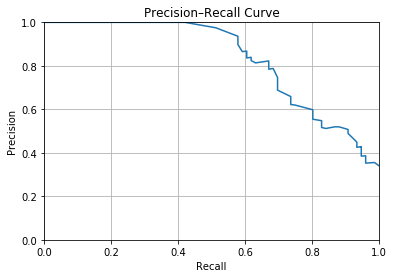

In [25]:
prc(y_val, predict_proba[:, 1])

In [26]:
oob_error = 1 - forest.oob_score_
print('Out-of-bag error: {}'.format(round(oob_error, 3)))

Out-of-bag error: 0.207
